Project #5: Video Stitching and Processing 

## CS445: Computational Photography

### Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# modify to where you store your project data including utils
datadir = "/content/drive/My Drive/cs445_projects/proj5/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

cp: /content/drive/My Drive/cs445_projects/proj5/utils.py: No such file or directory
cp: /content/drive/My Drive/cs445_projects/proj5/images: No such file or directory


In [2]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.17 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78)
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.17


### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [3]:
def score_projection(pt1, pt2):
    '''
    Score corresponding to the number of inliers for RANSAC
    Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
    Outputs: score (scalar count of inliers) and inliers (1xN logical array)


        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])
    '''
    du = pt2[0] -pt1[0]
    dv = pt2[1] - pt2[1]
    
    inliers = np.sqrt(du**2 + dv**2) < 0.6  # you may need to play with this threshold
    score = sum(inliers)
    
    return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    #print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [4]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''

    N = pts1.shape[1]
            
    A = np.zeros((2*N, 9))
    for i in range(N):
        A[2*i,:] = [-pts1[0,i],-pts1[1,i],-1,0,0,0,pts1[0,i]*pts2[0,i],pts1[1,i]*pts2[0,i],pts2[0,i]]
        A[2*i+1,:] = [0,0,0,-pts1[0,i],-pts1[1,i],-1,pts1[0,i]*pts2[1,i],pts1[1,i]*pts2[1,i],pts2[1,i]]
    
    H,S,V = svd(A)
    h = V[-1,:]
    
    H = np.reshape(h,(3,3))
    
    return H
    # TO DO
    



[[-4.88917984e-03 -2.37647400e-04  1.00000000e+00]
 [-7.80454138e-05 -4.69595650e-03  8.28684566e-02]
 [-1.71855517e-06 -1.41019902e-07 -4.05510072e-03]]


"\nim3 = './images/input/frames/f0630.jpg'\nim3 = cv2.imread(im3)\nH_13 = auto_homography(im1,im3, computeHomography)\nbox_pts_3 = H_13 @ box_pts\nfor i in range(5):  \n    box_pts_3[:,i] /= box_pts_3[2,i]\nax[2].imshow(im3[:,:,[2,1,0]])\nax[2].plot(box_pts_3[0,:], box_pts_3[1, :], 'r-')\n"

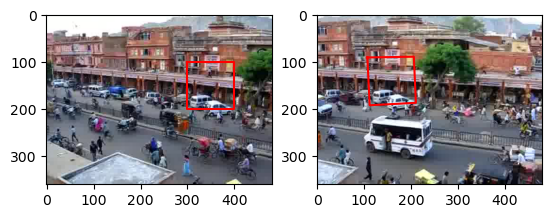

In [405]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'


# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

fig, ax = plt.subplots(nrows=1,ncols=2)

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
box_pts_2=H@box_pts
for i in range(5):  
    box_pts_2[:,i] /= box_pts_2[2,i]

ax[0].imshow(im1[:,:,[2,1,0]])
ax[0].plot(box_pts[0,:], box_pts[1, :], 'r-')
ax[1].imshow(im2[:,:,[2,1,0]])
ax[1].plot(box_pts_2[0,:], box_pts_2[1, :], 'r-')

'''
im3 = './images/input/frames/f0630.jpg'
im3 = cv2.imread(im3)
H_13 = auto_homography(im1,im3, computeHomography)
box_pts_3 = H_13 @ box_pts
for i in range(5):  
    box_pts_3[:,i] /= box_pts_3[2,i]
ax[2].imshow(im3[:,:,[2,1,0]])
ax[2].plot(box_pts_3[0,:], box_pts_3[1, :], 'r-')
'''
# TO DO: project points into im2 and display the projected lines on im2



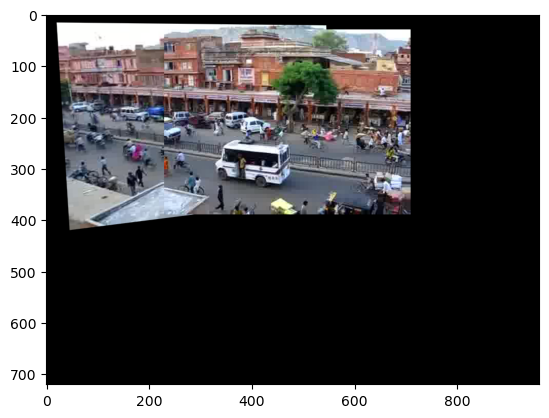

In [6]:
projectedWidth = 1600
projectedHeight = 500

# TO DO: warp and blend the two images

transformation_matrix = np.array([[1, 0, 270], [0, 1, 30], [0, 0, 1]])
warped_image = cv2.warpPerspective(im1, transformation_matrix.dot(H), (700, 500))
plt.imshow(warped_image)

max_w = max(len(im1), len(im2))
max_h = max(len(im1[1]), len(im2[1]))

canvas = np.zeros((int(max_w*2), int(max_h*2), 3))
canvas[:500, :700, :] = warped_image
canvas[30:30+360, 230:230+480, :] = im2
canvas = canvas.astype(np.uint8)
plt.imshow(canvas[:,:,[2,1,0]])

### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


(650, 1750, 3)


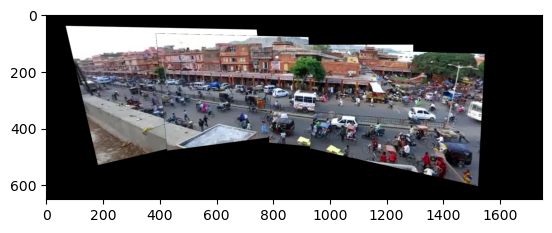

In [126]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

H_12 = auto_homography(frames[0],frames[1], computeHomography)
H_23 = auto_homography(frames[1],frames[2], computeHomography)
H_34 = auto_homography(frames[3],frames[2], computeHomography)
H_45 = auto_homography(frames[4],frames[3], computeHomography)
transformation_matrix = np.array([[1, 0, 650], [0, 1, 90], [0, 0, 1]])

warped_image_13 = cv2.warpPerspective(frames[0], transformation_matrix.dot(H_12 @ H_23), (1750, 650))
warped_image_23 = cv2.warpPerspective(frames[1], transformation_matrix.dot(H_23), (1750, 650))
warped_image_34 = cv2.warpPerspective(frames[3], transformation_matrix.dot(H_34), (1750, 650))
warped_image_35 = cv2.warpPerspective(frames[4], transformation_matrix.dot(H_34@H_45), (1750, 650))
warps=[warped_image_13, warped_image_23, warped_image_34, warped_image_35]

blended = warped_image_13
for i in range(len(warps)-1):
  mask =  warps[i+1]!= 0
  blended = blended*(1-mask)
  blended= blended+warps[i+1]
print(blended.shape)
blended = blended.astype(np.uint8)
plt.imshow(blended[:,:,[2,1,0]])


### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [198]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)


In [199]:
H_56 = auto_homography(frames[899],frames[810], computeHomography)

In [221]:
# TO DO part 3 solution
transformation_matrix = np.array([[1, 0, 650], [0, 1, 90], [0, 0, 1]])
#360h, 480w
blends = np.zeros((frameCount, 650, 1750, frameChannels),dtype='uint8')
homographies = np.zeros((frameCount, 3,3))
homographies[450]=np.eye(3)
homographies[630]=H_34
#homographies[810]=(H_34@H_45)
homographies[270]=(H_23)
homographies[899]=H_34@H_45@H_56
#homographies[90]=(H_12 @ H_23)

    
for i in range(898, -1, -1): 
     if i!=450 and i!=270 and i!=630:
        H_450 = auto_homography(frames[i],frames[i+1], computeHomography)
        H_temp= homographies[i+1]@H_450
        warped_image= cv2.warpPerspective(frames[i], transformation_matrix.dot(H_temp), (1750, 650))
        blended = warped_image.astype(np.uint8)
        blends[i]=blended     
        homographies[i]=H_temp


# create your video (see tips)

SyntaxError: incomplete input (2047036965.py, line 26)

In [201]:
blends[630]=warped_image_34
blends[270]=warped_image_23
#blends[810]=warped_image_35
blends[450,90:450, 650:1130, :]=frames[450]


In [224]:
for i in range(631, 642, 1):
        H_450 = auto_homography(frames[i],frames[i-1], computeHomography)
        H_temp= homographies[i-1]@H_450
        warped_image= cv2.warpPerspective(frames[i], transformation_matrix.dot(H_temp), (1750, 650))
        blended = warped_image.astype(np.uint8)
        blends[i]=blended     
        homographies[i]=H_temp

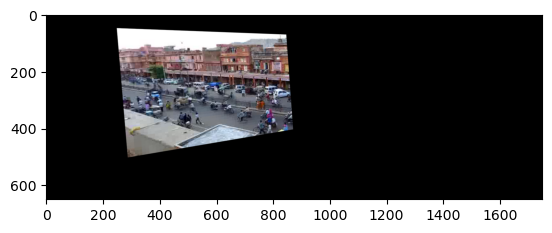

In [414]:
temp = blends[200,:,:,:]
plt.imshow(temp[:,:, [2,1,0]])

In [225]:
utils.vidwrite_from_numpy('output/video_1.mp4', blends[:,:,:,[2,1,0]], framerate=30)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/concourse/worker/volumes/live/d5b9ea1c-8223-4ff6-7416-83e6b4cd6874/volume/ffmpeg_1587154914508/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehol --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilt

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [226]:
# TO DO part 4

background = np.zeros((512, 1632, 3))
for i in range(512):
    for j in range(1632):
        for c in range(3):
            mask = np.nonzero(blends[:, i, j, c])
            if len(mask) != 0:
                background[i][j][c] = np.median(blends[mask, i, j, c]/255)
    

/Users/djbautista/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/djbautista/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/djbautista/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


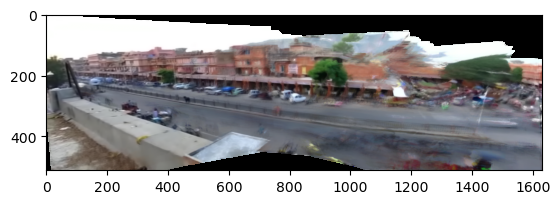

In [227]:
plt.imshow(background[:,:,[2,1,0]])

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [264]:
# TO DO part 5
background_blends= np.zeros((frameCount, 360, 480, frameChannels))

for i in range(900):
    background_blends[i] = cv2.warpPerspective(background,np.linalg.pinv(transformation_matrix.dot(homographies[i])), (480, 360))

        #projected_background = cv2.warpPerspective(background, np.linalg.pinv(H_t.dot(pastHomographies[i][449])), (480, 360))



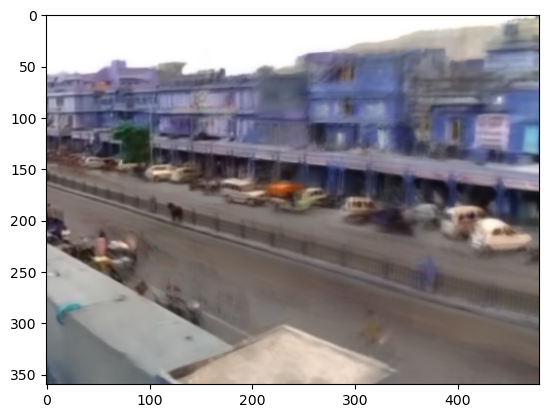

In [418]:
plt.imshow(background_blends[200])

In [270]:
utils.vidwrite_from_numpy('output/video_2.mp4', background_blends[:,:,:,[2,1,0]]*255, framerate=30)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/concourse/worker/volumes/live/d5b9ea1c-8223-4ff6-7416-83e6b4cd6874/volume/ffmpeg_1587154914508/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehol --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilt

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [436]:
# TO DO part 6
foreground_blends= np.zeros((frameCount, 360, 480, frameChannels), dtype='float')
for i in range(len(frames)):
    foreground_blends[i]=(frames[i]-(background_blends[i]*255))


In [452]:
foreground_blends1=foreground_blends/85
foreground_blends1=foreground_blends1.astype(np.uint8)
foreground_blends1=foreground_blends1*200


/var/folders/ly/nh9w4k6j10v0s__24_nmfmnr0000gn/T/ipykernel_97294/345585324.py:2: RuntimeWarning: invalid value encountered in cast
  foreground_blends1=foreground_blends1.astype(np.uint8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


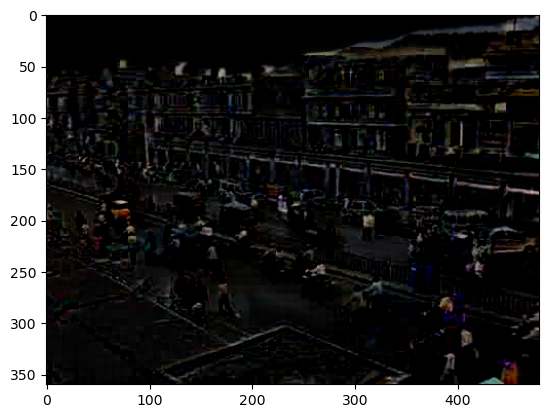

In [448]:
plt.imshow(foreground_blends[200]/255)

In [453]:
utils.vidwrite_from_numpy('output/video_3.mp4', foreground_blends1[:,:,:,[2,1,0]], framerate=30)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/concourse/worker/volumes/live/d5b9ea1c-8223-4ff6-7416-83e6b4cd6874/volume/ffmpeg_1587154914508/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehol --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilt

## Bells and whistles

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.99354703 1.         0.99677351]
  [0.99375    1.         0.996875  ]
  [0.99221048 1.         0.99610524]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.99742647 1.         0.99871324]
  [0.99767157 1.         0.99883578]
  [0.99558824 1.         0.99779412]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.47401961 0.43867187 0.41342678]
  [0.47573529 0.43794807 0.41184513]
  [0.47436428 0.43884804 0.41176471]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


In [459]:
totals= np.zeros((frameCount, 360, 480, frameChannels))

for i in range(900):
    totals[i] = foreground_blends[i]+(background_blends[i]*255)

In [458]:
utils.vidwrite_from_numpy('output/video_4.mp4', totals[:,:,:,[2,1,0]], framerate=30)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/concourse/worker/volumes/live/d5b9ea1c-8223-4ff6-7416-83e6b4cd6874/volume/ffmpeg_1587154914508/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehol --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilt